# Direção de magnetização de corpos aproximadamente esféricos

## Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sphere_mag

In [3]:
import prism_mag

In [4]:
import sphere_kernels

## Gerando as coordenadas de observação

In [5]:
Nx = 100
Ny = 50
area = [-1000.,1000.,-1000.,1000.]
shape = (Nx,Ny)

In [6]:
x = np.linspace(area[0],area[1],num=Nx)
y = np.linspace(area[2],area[3],num=Ny) 
yc,xc = np.meshgrid(y,x)

In [7]:
voo = -100.
zc = voo*np.ones_like(xc)

In [8]:
coordenadas = np.array([yc.ravel(),xc.ravel(),zc.ravel()])

## Gerando os parâmetros do prisma

In [9]:
intensidades = np.array([50.])

In [10]:
direcoes = np.array([[-40.,-50.]])

In [11]:
modelo = np.array([[-100,100,-100,100,200,400]])

## Cálculo das componentes do campo de gravidade e do potencial

In [12]:
bz = prism_mag.magnetics(coordenadas,modelo,intensidades,direcoes,field="b_z")

In [13]:
bx = prism_mag.magnetics(coordenadas,modelo,intensidades,direcoes,field="b_x")

In [14]:
by = prism_mag.magnetics(coordenadas,modelo,intensidades,direcoes,field="b_y")

### Anomalia de campo total aproximada

In [15]:
I0,D0 = -20.,-20.
j0x = np.cos(np.deg2rad(I0))*np.cos(np.deg2rad(D0))
j0y = np.cos(np.deg2rad(I0))*np.sin(np.deg2rad(D0))
j0z = np.sin(np.deg2rad(I0))
tfa = j0x*bx + j0y*by + j0z*bz

### Gerando um conjunto de dados observados com ruído Gaussiano

In [16]:
np.random.seed(seed=40)
std_noise = 0.03*np.max(np.abs(tfa))

r = np.random.normal(0.0, std_noise, tfa.size)

print ('%.3f nT' % std_noise)

15.085 nT


In [17]:
tfa_obs = tfa + r

## Visualização dos dados calculados 

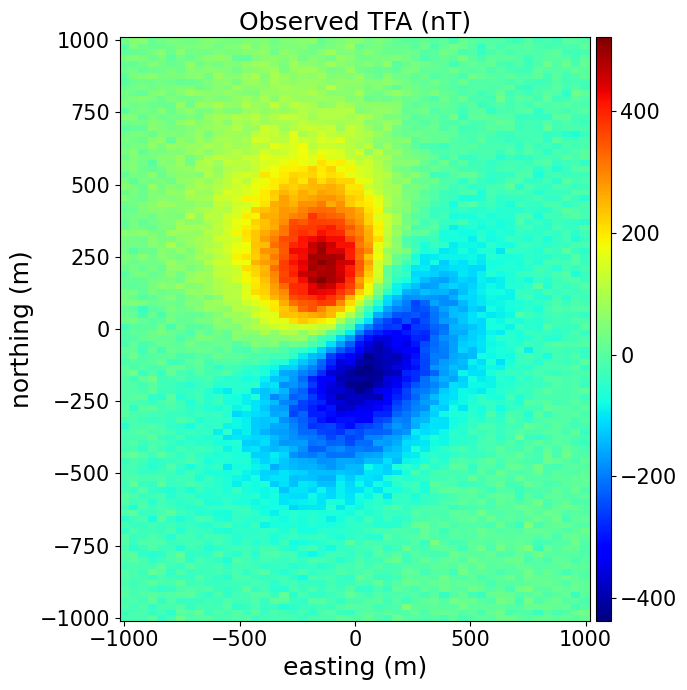

In [18]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_obs.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/observed_TFA'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

## Resolvendo o problema inverso de estimar a direção de magnetização de uma esfera

In [19]:
main_field = np.array([-20.,-20.])
model = np.array([[0.,0.,300.,10.]])

In [20]:
G = sphere_kernels.sensitivity(coordenadas,model,main_field)

In [21]:
p = np.linalg.solve(np.dot(G.T,G),np.dot(G.T,tfa_obs))

### Análise dos resultados da inversão

In [22]:
mx,my,mz = p

In [23]:
intensity = np.sqrt(mx*mx + my*my + mz*mz)
r2d = 180. / np.pi
D = r2d*np.arctan2(my,mx)
I = r2d*np.arctan2(mz,np.sqrt(mx*mx + my*my))

In [24]:
print ('Intensity = %.2f A/m' % intensity )
print ('Inclination = %.2f degrees' % I )
print ('Declination = %.2f degrees' % D )

Intensity = 95140.56 A/m
Inclination = -39.94 degrees
Declination = -50.02 degrees


In [25]:
intensidade_estimada = np.array([intensity])
direcao_estimada = np.array([[I,D]])

In [26]:
bz_pred = sphere_mag.magnetics(coordenadas,model,intensidade_estimada,direcao_estimada,field="b_z")
by_pred = sphere_mag.magnetics(coordenadas,model,intensidade_estimada,direcao_estimada,field="b_y")
bx_pred = sphere_mag.magnetics(coordenadas,model,intensidade_estimada,direcao_estimada,field="b_x")

In [27]:
I0,D0 = -20.,-20.
j0x = np.cos(np.deg2rad(I0))*np.cos(np.deg2rad(D0))
j0y = np.cos(np.deg2rad(I0))*np.sin(np.deg2rad(D0))
j0z = np.sin(np.deg2rad(I0))
tfa_pred = j0x*bx_pred + j0y*by_pred + j0z*bz_pred

In [28]:
residuals = tfa_obs - tfa_pred
mean = np.mean(residuals)
std_deviation = np.std(residuals)

### Comparando dado observado com dado predito

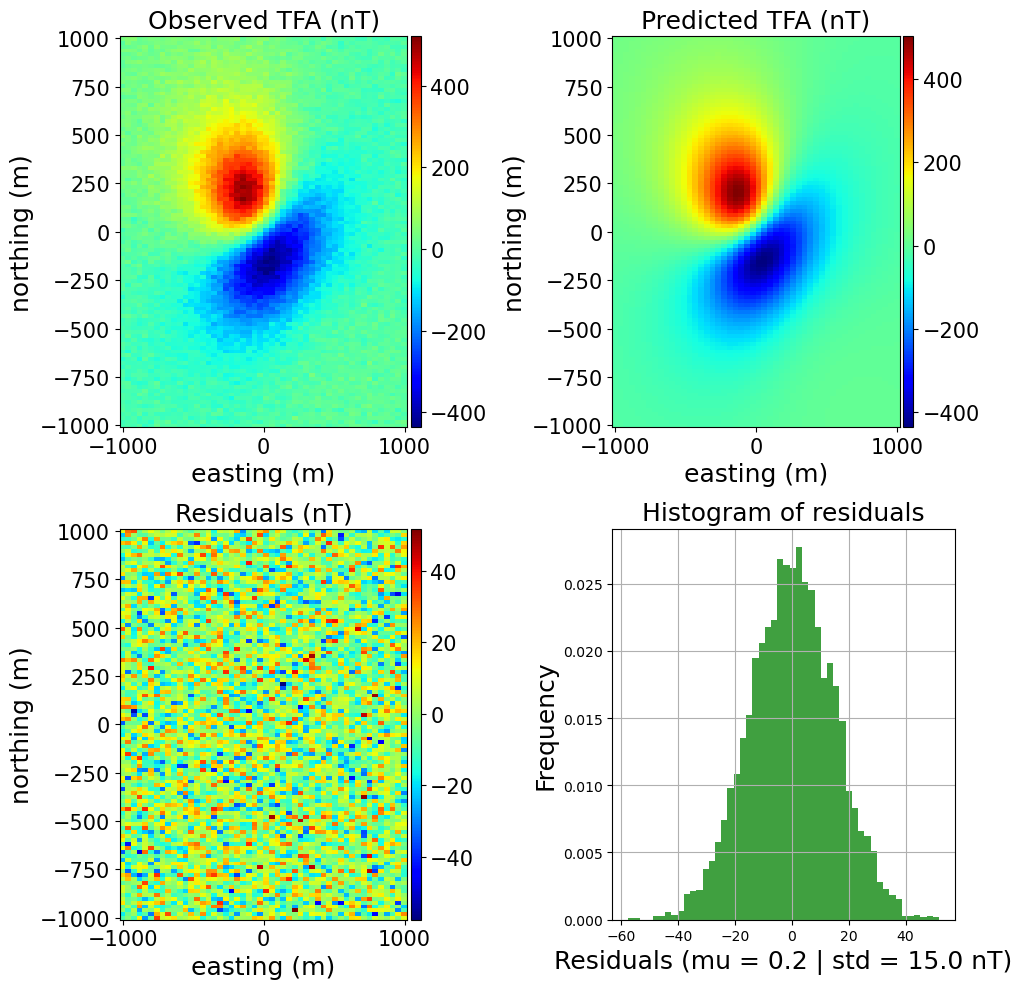

In [29]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(10,10), tight_layout=True)

plt.subplot(2,2,1)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_obs.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,2)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Predicted TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_pred.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,3)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Residuals (nT)', fontsize=title_font)
plt.pcolor(yc,xc,residuals.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,4)
n, bins, patches = plt.hist(residuals, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Residuals (mu = %.1f | std = %.1f nT)' % (mean,std_deviation),fontsize = title_font)
plt.ylabel('Frequency',fontsize = title_font)
plt.title('Histogram of residuals',fontsize = title_font)
plt.grid(True)

file_name = 'images/data_fitting'
plt.savefig(file_name+'.png',dpi=300)

plt.show()